In [ ]:
# SET HERE YOUR WORKING PATH to the shared directory SL_Project
path_chiara = '/content/drive/MyDrive/POLIMI/StatLearn/SL_Project'
path_due = '/content/drive/MyDrive/SL_Project'

path = path_due

# Pre-Ops

---



### Mount google drive
Before starting We need to connect the Google Drive storage to the notebook. We can mount google drive by using the google colab api. Then, we create a shortcut to drive's folder. 

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

# Insert here the path of the working folder
os.chdir(path)

# Check the currect working directory
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1PJmLRBcjNS-z-lCoZx4N6VKkZMoUdJyS/SL_Project'

###Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
%matplotlib inline
from sklearn.preprocessing import StandardScaler

# Utils

In [ ]:
primary_drug_categories = {
   "Diuretics": ['Furosemide tablet', 'Furosemide injection', 'Torasemide tablet', 'Spironolactone tablet', 'Hydrochlorothiazide tablet'],
   "Inotropes": ['Deslanoside injection', 'Dobutamine hydrochloride injection','Digoxin tablet', 'Milrinone injection', 'Isoprenaline Hydrochloride injection', 'Meglumine Adenosine Cyclophosphate for injection'],
   "Vasodilators": ['Isosorbide Mononitrate Sustained Release tablet', 'Nitroglycerin injection'],
   "LDL controller": ['Atorvastatin calcium tablet'],
   "ARB dispersible": ['Valsartan Dispersible tablet'],
   "ACE inhibitors": ['Benazepril hydrochloride tablet'],
   "Chinese traditional treatments": ['sulfotanshinone sodium injection', 'Shenfu injection'],
 } 

In [ ]:
def describe_df(df, name, patient_col):
  print(f"\033[33m{name}\033[0m:")
  print(" shape: ", df.shape)
  print(" unique patients: ", df[patient_col].nunique())
  print(" columns: ", df.columns)
  print("")

In [ ]:
def expand_df_binary_drugs(df_general_, df_drug_grouped_, patient_col, drug_col, set_of_drug, drug_categories):
  # This function creates a new dataframe having 
  # for each patient in general_df (identified by the field patient_col)
  # a feature vector containing as many binary variables as the number of drugs in set_of_drug
  # each of which identifies if the patient's treatment includes that drug (1) or not (0)
  # according to the treatment reported in the dataset df_drug_grouped in the field drug_col
  
  # getting the patients 
  expanded_df_g = df_drug_grouped_[[patient_col]].copy()

  # expanding the set of drugs for each patient
  # considering each drug apart from others:
  for drug in set_of_drug:
    expanded_df_g.loc[:, drug] = df_drug_grouped_[drug_col].apply(lambda x: True if (drug in x) else False)
  
  # # expanding the set of drugs for each patient
  # # considering each drug category apart from others:
  for category,drugs in primary_drug_categories.items():
    expanded_df_g.loc[:, category] = expanded_df_g[drugs].sum(axis=1)>0

  expanded_df = df_general_[[patient_col]].copy()
  expanded_df = pd.merge(expanded_df, expanded_df_g, on='inpatient.number', how='left')
  expanded_df = expanded_df.replace(np.NaN, 0)

  return expanded_df

# Preliminary analysis

We are provided with 2 dataset:
- GENERAL DATASET
  - filename: 'dat.csv' 
  - number of patients: 2008
  - datapoint structure: (patient_ID ; feature_vector)
  - feature_vector: 165 variables

- DRUG DATASET 
  - filename: 'dat_md.csv' 
  - number of patients: 2004
  - datapoint structure: (patient_ID ; drug)
  - total number of datapoints: 12654
  - total number of drugs: 18


### Files exploration
Understanding the content of the two files

In [ ]:
dataset_path_general = path+"/Data/dat.csv"  
dataset_path_drugs = path+"/Data/dat_md.csv" 

In [ ]:
df_general = pd.read_csv(dataset_path_general).drop(['Unnamed: 0'], axis=1)
df_drugs = pd.read_csv(dataset_path_drugs).drop(['Unnamed: 0'], axis=1)

describe_df(df_general, "General dataset", 'inpatient.number')
describe_df(df_drugs, "Drug dataset", 'inpatient.number')

General dataset:
 shape:  (2008, 166)
 unique patients:  2008
 columns:  Index(['inpatient.number', 'DestinationDischarge', 'admission.ward',
       'admission.way', 'occupation', 'discharge.department', 'visit.times',
       'gender', 'body.temperature', 'pulse',
       ...
       'body.temperature.blood.gas', 'oxygen.saturation',
       'partial.oxygen.pressure', 'oxyhemoglobin', 'anion.gap', 'free.calcium',
       'total.hemoglobin', 'GCS', 'dischargeDay', 'ageCat'],
      dtype='object', length=166)

Drug dataset:
 shape:  (12654, 2)
 unique patients:  2004
 columns:  Index(['inpatient.number', 'Drug_name'], dtype='object')



In [ ]:
def build_nan_counts_df(df):
    nan_counts = df.isna().sum()
    columns_with_nans = nan_counts[nan_counts > 0].index
    
    nan_counts_df = pd.DataFrame({'Column': columns_with_nans, 'NaN Count': nan_counts[columns_with_nans]}, ).reset_index(drop=True)
    nan_counts_df['Var type'] = nan_counts_df['Column'].apply(lambda x: df[x].dtype)
    
    return nan_counts_df 

df_nan = build_nan_counts_df(df_general)
df_nan.to_csv('check_for_nans.csv', index=False)

### Drug set handling
Preparing the drug set for make it in a usable form that is compliant with the general dataset

In [ ]:
df_drug_grouped = df_drugs.groupby('inpatient.number')['Drug_name'].apply(set).reset_index()
describe_df(df_drug_grouped, "Grouped drug dataset", 'inpatient.number')

Grouped drug dataset:
 shape:  (2004, 2)
 unique patients:  2004
 columns:  Index(['inpatient.number', 'Drug_name'], dtype='object')



In [ ]:
print("Missing patients in drug dataset:          ",[pat for pat in df_general['inpatient.number'].unique() if pat not in df_drugs['inpatient.number'].unique()])
print("Missing patients in grouped drug dataset:  ",[pat for pat in df_general['inpatient.number'].unique() if pat not in df_drug_grouped['inpatient.number'].unique()])

Missing patients in drug dataset:           [863648, 796480, 789308, 829624]
Missing patients in grouped drug dataset:   [863648, 796480, 789308, 829624]


In [ ]:
drug_set = df_drugs['Drug_name'].unique()
print("Tot num. of drugs: ", drug_set.shape[0])
print("Drugs: ", drug_set) 

Tot num. of drugs:  18
Drugs:  ['sulfotanshinone sodium injection' 'Furosemide tablet'
 'Meglumine Adenosine Cyclophosphate for injection' 'Furosemide injection'
 'Milrinone injection' 'Deslanoside injection' 'Torasemide tablet'
 'Benazepril hydrochloride tablet' 'Atorvastatin calcium tablet'
 'Digoxin tablet' 'Hydrochlorothiazide tablet' 'Spironolactone tablet'
 'Valsartan Dispersible tablet' 'Dobutamine hydrochloride injection'
 'Isoprenaline Hydrochloride injection' 'Nitroglycerin injection'
 'Shenfu injection' 'Isosorbide Mononitrate Sustained Release tablet']


In [ ]:
df_drug_grouped.head() 

,inpatient.number,Drug_name
0,722128,"{Deslanoside injection, Furosemide tablet, Fur..."
1,723327,"{Deslanoside injection, Isosorbide Mononitrate..."
2,723617,"{Furosemide injection, Spironolactone tablet, ..."
3,724385,"{Deslanoside injection, Furosemide tablet, Fur..."
4,725509,"{Deslanoside injection, Torasemide tablet, Fur..."


### Drugs

```
Tot num. of drugs:  18

Drugs:  ['sulfotanshinone sodium injection' 'Furosemide tablet'
 'Meglumine Adenosine Cyclophosphate for injection' 'Furosemide injection'
 'Milrinone injection' 'Deslanoside injection' 'Torasemide tablet'
 'Benazepril hydrochloride tablet' 'Atorvastatin calcium tablet'
 'Digoxin tablet' 'Hydrochlorothiazide tablet' 'Spironolactone tablet'
 'Valsartan Dispersible tablet' 'Dobutamine hydrochloride injection'
 'Isoprenaline Hydrochloride injection' 'Nitroglycerin injection'
 'Shenfu injection' 'Isosorbide Mononitrate Sustained Release tablet']
```



Primary drug categories included in the dataset were:
- diuretics (furosemide, torsemide, spironolactone (provided) + Hydrochlorothiazide (by research))
- inotropes (deslanoside, dobutamine, digoxin, isoprenaline and milrinone (provided) + Meglumine Adenosine Cyclophosphate (by research))
- vasodilators (isosorbide mononitrate and nitroglycerin)
- LDL colesterol reduction (Atorvastatin calcium)
- ACE inhibitors (Benazepril hydrochloride)
- ARB (Valsartan Dispersible)
- Chinese traditional medicine

Reference: dataset description (https://www.physionet.org/content/heart-failure-zigong/1.2/)

### Type of drugs explanation



- DIURETICS: In the context of heart failure treatment, diuretics are medications that are used to reduce the fluid buildup in the lungs and other tissues that occurs in heart failure patients. By increasing urine output, diuretics help to decrease the volume of fluid in the body, which can reduce the workload on the heart and improve symptoms such as shortness of breath and swelling in the legs. However, diuretics do not directly improve heart function and should be used in conjunction with other medications and therapies as part of a comprehensive treatment plan.


- VASODILATORS: Vasodilators are drugs that widen or dilate blood vessels, particularly arteries and arterioles, leading to increased blood flow and reduced blood pressure. They work by relaxing the smooth muscle cells in the walls of blood vessels through various mechanisms.


- INOTROPES: An inotrope is a drug or substance that increases the contractile force of the heart muscle, or myocardium. Inotropes are primarily used in the treatment of heart failure, a condition in which the heart is unable to pump enough blood to meet the body's needs. Inotropes can help improve blood flow and perfusion to vital organs such as the brain and kidneys. However, inotropes can also have side effects and risks, such as increased oxygen consumption by the heart and reduced blood pressure.


- ACE INHIBITORS: ACE inhibitors (angiotensin-converting enzyme inhibitors) are medications used for the treatment of hypertension (high blood pressure) and congestive heart failure. They work by relaxing blood vessels, which helps to lower blood pressure and improve blood flow. 


- ARB: Angiotensin II receptor blocker (ARB) is a type of  medications used to treat high blood pressure (hypertension), heart failure, and to improve survival after a heart attack. The dispersible formulation of valsartan is a type of tablet that can be dissolved in water or other liquids before taking it. This can make it easier for people who have difficulty swallowing tablets, such as older adults or people with certain medical conditions, to take their medication.

- CHINESE TRADITIONAL MEDICINE: sulfotanshinone sodium, is a synthetic form of tanshinone, a compound found in the root of the Chinese medicinal herb Salvia miltiorrhiza. It is used in traditional Chinese medicine to treat a variety of conditions, including cardiovascular disease, stroke, and liver disease. Shenfu injection is a traditional Chinese medicine that contains ginseng and aconite as its active ingredients. It is a sterile solution for injection that is used to treat a variety of conditions, including cardiovascular disease, shock, and acute respiratory distress syndrome.

# Dataset Preparation
Building a unique dataset from all data available in a usable form for the task

In [ ]:
dataset_path_general = path+"/Data/dat.csv"
dataset_path_drugs = path+"/Data/dat_md.csv"

In [ ]:
def prepare_dataset(general_data_path, drugs_data_path, primary_drug_categories):
  df_general = pd.read_csv(general_data_path).drop(['Unnamed: 0'], axis=1)
  df_drugs = pd.read_csv(drugs_data_path).drop(['Unnamed: 0'], axis=1)

  df_drug_grouped = df_drugs.groupby('inpatient.number')['Drug_name'].apply(set).reset_index()
  drug_set = df_drugs['Drug_name'].unique()

  expanded_df_general = expand_df_binary_drugs(df_general, df_drug_grouped, 'inpatient.number', 'Drug_name', drug_set, primary_drug_categories)

  df = pd.merge(df_general, expanded_df_general, on='inpatient.number')
  df.rename(columns={"inpatient.number": "Patient_ID"}, inplace=True)

  return df

In [ ]:
dataset = prepare_dataset(dataset_path_general, dataset_path_drugs, primary_drug_categories)

### Explore and check

In [ ]:
describe_df(dataset, 'Starting point dataset', 'Patient_ID')

Starting point dataset:
 shape:  (2008, 191)
 unique patients:  2008
 columns:  Index(['Patient_ID', 'DestinationDischarge', 'admission.ward', 'admission.way',
       'occupation', 'discharge.department', 'visit.times', 'gender',
       'body.temperature', 'pulse',
       ...
       'Nitroglycerin injection', 'Shenfu injection',
       'Isosorbide Mononitrate Sustained Release tablet', 'Diuretics',
       'Inotropes', 'Vasodilators', 'LDL controller', 'ARB dispersible',
       'ACE inhibitors', 'Chinese traditional treatments'],
      dtype='object', length=191)



In [ ]:
dataset

,Patient_ID,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,...,Nitroglycerin injection,Shenfu injection,Isosorbide Mononitrate Sustained Release tablet,Diuretics,Inotropes,Vasodilators,LDL controller,ARB dispersible,ACE inhibitors,Chinese traditional treatments
0,857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,...,False,False,False,True,True,False,True,False,True,True
1,743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95,...,False,False,False,True,False,False,False,False,False,False
2,866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98,...,False,False,False,True,True,False,False,True,False,False
3,775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73,...,False,False,False,True,True,False,True,True,False,False
4,810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88,...,False,False,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,740689,HealthcareFacility,GeneralWard,Emergency,Others,GeneralWard,1,Female,36.1,117,...,False,False,False,True,True,False,False,False,False,False
2004,734280,HealthcareFacility,GeneralWard,Emergency,UrbanResident,GeneralWard,1,Female,36.3,70,...,False,False,False,True,True,False,False,False,False,False
2005,781004,HealthcareFacility,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.8,113,...,False,True,False,True,True,False,False,False,True,True
2006,744870,Unknown,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.4,134,...,False,False,False,True,True,False,False,False,False,False


In [ ]:
def get_num_of_categories(drug_list):
  cat = set()
  for d in drug_list:
    for c,drugs in primary_drug_categories.items(): 
      if d in drugs: cat.add(c)
  return len(set(cat))

def check_expanded(df_expanded):

  patient_col = 'Patient_ID'
  drug_col = 'Drug_name'

  primary_drug_categories = {
   "Diuretics": ['Furosemide tablet', 'Furosemide injection', 'Torasemide tablet', 'Spironolactone tablet', 'Hydrochlorothiazide tablet'],
   "Inotropes": ['Deslanoside injection', 'Dobutamine hydrochloride injection','Digoxin tablet', 'Milrinone injection', 'Isoprenaline Hydrochloride injection', 'Meglumine Adenosine Cyclophosphate for injection'],
   "Vasodilators": ['Isosorbide Mononitrate Sustained Release tablet', 'Nitroglycerin injection'],
   "LDL controller": ['Atorvastatin calcium tablet'],
   "ARB dispersible": ['Valsartan Dispersible tablet'],
   "ACE inhibitors": ['Benazepril hydrochloride tablet'],
   "Chinese traditional treatments": ['sulfotanshinone sodium injection', 'Shenfu injection'],
   } 
  
  drug_columns = ['sulfotanshinone sodium injection', 'Furosemide tablet', 'Meglumine Adenosine Cyclophosphate for injection', 
                  'Furosemide injection', 'Milrinone injection', 'Deslanoside injection', 'Torasemide tablet', 'Benazepril hydrochloride tablet', 
                  'Atorvastatin calcium tablet', 'Digoxin tablet', 'Hydrochlorothiazide tablet', 'Spironolactone tablet', 'Valsartan Dispersible tablet', 
                  'Dobutamine hydrochloride injection', 'Isoprenaline Hydrochloride injection', 'Nitroglycerin injection', 'Shenfu injection', 
                  'Isosorbide Mononitrate Sustained Release tablet']

  cat_columns = ['Chinese traditional treatments', 'Diuretics', 'Inotropes', 'ACE inhibitors', 'LDL controller', 'ARB dispersible', 'Vasodilators']

  all_columns = [patient_col] + drug_columns + cat_columns

  df_expanded_drugs = df_expanded[all_columns]

  df_general = pd.read_csv(dataset_path_general).drop(['Unnamed: 0'], axis=1)
  df_general.rename(columns={"inpatient.number": "Patient_ID"}, inplace=True)
  df_drugs = pd.read_csv(dataset_path_drugs).drop(['Unnamed: 0'], axis=1)
  df_drugs.rename(columns={"inpatient.number": "Patient_ID"}, inplace=True)
  df_drug_grouped = df_drugs.groupby(patient_col)['Drug_name'].apply(set).reset_index()

  patients_with_missing_drug = [pat for pat in df_general[patient_col].unique() if pat not in df_drug_grouped[patient_col].unique()]
  notindrug = df_expanded_drugs[df_expanded_drugs[patient_col].isin(patients_with_missing_drug)]
  indrug = df_expanded_drugs[~df_expanded_drugs[patient_col].isin(patients_with_missing_drug)]

  df1 = df_drug_grouped[[patient_col]].copy()
  df1.loc[:,'num of drugs'] = df_drug_grouped[drug_col].apply(lambda x: len(x))
  df1.loc[:,'num of categories'] = df_drug_grouped[drug_col].apply(lambda x: int(get_num_of_categories(x)))
  
  df2 = df_expanded_drugs[[patient_col]].copy()
  df2['num of drugs 2'] = df_expanded_drugs[drug_columns].sum(axis=1).apply(lambda x: int(x))
  df2['num of categories 2'] = df_expanded_drugs[cat_columns].sum(axis=1).apply(lambda x: int(x))
  df = pd.merge(df1, df2, on= patient_col)
  
  print("All patients not in drug dataset have all zeros as drug_feature_vector: ", (notindrug.drop(columns=[patient_col]).sum(axis=1).sum(axis=0) == 0))
  print("All patients in drug dataset have exactly the same number of drugs as in the dataset: ",  df['num of drugs'].equals(df['num of drugs 2']))
  print("All patients in drug dataset have exactly the same number of categories as in the dataset: ",  df['num of categories'].equals(df['num of categories 2']))
  
  return df, indrug

[df, indrug] = check_expanded(dataset)

All patients not in drug dataset have all zeros as drug_feature_vector:  True
All patients in drug dataset have exactly the same number of drugs as in the dataset:  True
All patients in drug dataset have exactly the same number of categories as in the dataset:  True


# Target analysis

Here we determine and prepare the target accoridng to the task and the features available.

Considering the study's focus on readmission within 6 months following the hospitalization under investigation, all the information available in the original dataset regarding follow‐up visits at 28 days, 3 months and 6 months, the return to emergency department within 6 months and the possibility of death within the 6-month period were aggregated in a single Outcome feature, to be later used as target variable. 


In [ ]:
# Exclude from the dataset usless information, in this case the features that are logically already included in other variables of interest:
# - readmitted after 3 months => readmitted within 6 months
# - readmitted after 28 days => readmitted within 6 months
# - death within 3 months => death within 6 months
# - death within 28 days => death within 6 months
dataset.drop(columns=['re.admission.within.3.months','death.within.3.months','death.within.28.days','re.admission.within.28.days'], inplace=True)

In [ ]:
correspondent = len(dataset[dataset['return.to.emergency.department.within.6.months'] == dataset['re.admission.within.6.months']])
print(f"The return to emergency feature and the readmission within 6 month feature correspond in {correspondent/len(dataset)*100: .{2}f} % of the samples.")

The return to emergency feature and the readmission within 6 month feature correspond in  99.25 % of the samples.


In [ ]:
dataset.drop(columns=['return.to.emergency.department.within.6.months', 'time.to.emergency.department.within.6.months'], inplace=True)

In [ ]:
[x for x in dataset.columns if 'within' in x]

['death.within.6.months', 're.admission.within.6.months']

In [ ]:
# Add to the dataset the Outcome column as 

# Define a dictionary for mapping
mapping = {0: "Not readmitted", 1: "Readmitted", 2: "Dead"}

dataset['Outcome'] = dataset['re.admission.within.6.months']

for index, row in dataset.iterrows():
  if row['death.within.6.months']==1: 
    dataset.loc[index,'Outcome'] = 2

# and keep only the outcome 
dataset.drop(columns=['re.admission.within.6.months','death.within.6.months'], inplace=True)
dataset

,Patient_ID,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,...,Shenfu injection,Isosorbide Mononitrate Sustained Release tablet,Diuretics,Inotropes,Vasodilators,LDL controller,ARB dispersible,ACE inhibitors,Chinese traditional treatments,Outcome
0,857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,...,False,False,True,True,False,True,False,True,True,0
1,743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95,...,False,False,True,False,False,False,False,False,False,0
2,866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98,...,False,False,True,True,False,False,True,False,False,0
3,775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73,...,False,False,True,True,False,True,True,False,False,1
4,810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88,...,False,False,True,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,740689,HealthcareFacility,GeneralWard,Emergency,Others,GeneralWard,1,Female,36.1,117,...,False,False,True,True,False,False,False,False,False,0
2004,734280,HealthcareFacility,GeneralWard,Emergency,UrbanResident,GeneralWard,1,Female,36.3,70,...,False,False,True,True,False,False,False,False,False,0
2005,781004,HealthcareFacility,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.8,113,...,True,False,True,True,False,False,False,True,True,1
2006,744870,Unknown,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.4,134,...,False,False,True,True,False,False,False,False,False,2


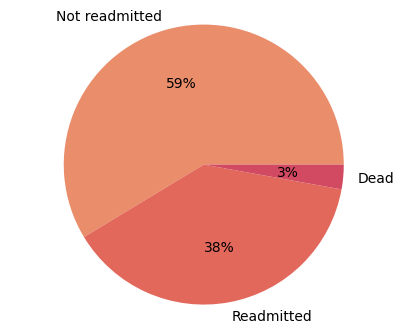

In [ ]:
def plot_pie_chart(df, target_column, mapping):
    # Extract the target column from the DataFrame
    target_values = df[target_column]
    
    # Calculate the value counts for each category in the target column
    category_counts = target_values.value_counts()
    
    # Define the labels for the pie chart using the index of the value counts
    labels = category_counts.index

    # Create a mapping function
    map_func = np.vectorize(lambda value: mapping.get(value, "unknown"))
    # Map the array to string values
    labels = map_func(labels)
    
    #define Seaborn color palette to use
    colors = sns.color_palette("flare")[0:5]
    
    # Plot the pie chart
    plt.figure(figsize=(5, 4))  # Optional: Adjust the figure size
    plt.pie(category_counts, labels = labels, colors = colors, autopct='%.0f%%')
    plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.show()

plot_pie_chart(dataset, 'Outcome', mapping)

In [ ]:
print("Dataset dimensions", dataset.shape)

Dataset dimensions (2008, 184)


In [ ]:
dataset.drop(index = dataset[dataset['Outcome'] == 2].index, inplace = True)

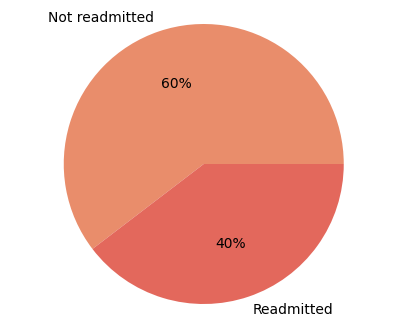

Dataset dimensions (1951, 184)


In [ ]:
plot_pie_chart(dataset, 'Outcome', mapping)
print("Dataset dimensions", dataset.shape)

# Dead patients and discharge management

Here we analyse the variables related to the outcome both in terms of discharge or death. In particular, all patients that resulted to be dead before the discharge are dropped. 

We go from 2008  to 1992 patients (16 patients dropped).

In [ ]:
dataset.rename(columns={"outcome.during.hospitalization": "outcome_during_hospitalization"}, inplace=True)

# Dropping the patients that resulted to be died in the column DestinationDischarge
dataset = dataset.drop(dataset[dataset.DestinationDischarge == 'Died'].index)

# Dropping the patients that resulted to be died in the column outcome_during_hospitalization
dataset = dataset.drop(dataset[dataset.outcome_during_hospitalization == 'Dead'].index)

dataset 

,Patient_ID,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,...,Shenfu injection,Isosorbide Mononitrate Sustained Release tablet,Diuretics,Inotropes,Vasodilators,LDL controller,ARB dispersible,ACE inhibitors,Chinese traditional treatments,Outcome
0,857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,...,False,False,True,True,False,True,False,True,True,0
1,743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95,...,False,False,True,False,False,False,False,False,False,0
2,866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98,...,False,False,True,True,False,False,True,False,False,0
3,775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73,...,False,False,True,True,False,True,True,False,False,1
4,810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88,...,False,False,True,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,754589,HealthcareFacility,GeneralWard,Emergency,UrbanResident,GeneralWard,1,Female,36.5,100,...,False,False,True,True,False,True,False,False,True,0
2003,740689,HealthcareFacility,GeneralWard,Emergency,Others,GeneralWard,1,Female,36.1,117,...,False,False,True,True,False,False,False,False,False,0
2004,734280,HealthcareFacility,GeneralWard,Emergency,UrbanResident,GeneralWard,1,Female,36.3,70,...,False,False,True,True,False,False,False,False,False,0
2005,781004,HealthcareFacility,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.8,113,...,True,False,True,True,False,False,False,True,True,1


# Splitting the dataset

In [ ]:
#dataset split
data = dataset
X_train, X_test, y_train, y_test = train_test_split(data, data['Outcome'], test_size = 0.2, random_state = 42, stratify = data['Outcome'])

print("Train dimensions", X_train.shape)
print("Test dimensions", X_test.shape)
print("Training df has same length of its output vector?", X_train.shape[0] == y_train.shape[0])
print("Test df has same length of its output vector?", X_test.shape[0] == y_test.shape[0])

Train dimensions (1556, 184)
Test dimensions (390, 184)
Training df has same length of its output vector? True
Test df has same length of its output vector? True


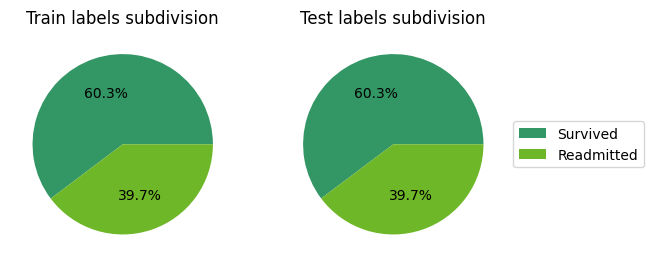

In [ ]:
#create vectors
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)
labels = ['Survived', 'Readmitted', 'Dead']
colors = ['#339665', '#6eb728', '#4a5e46' ]

#plot
plt.subplot(1, 2, 1)
plt.pie(train_counts, colors = colors, autopct='%1.1f%%')
plt.title('Train labels subdivision')
plt.subplot(1, 2, 2)
plt.pie(test_counts,colors = colors, autopct='%1.1f%%')
plt.title('Test labels subdivision')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Preliminary drop of variables with too many null values

To reduce the burden of the preliminatory analysis we start dropping columns with > 60% NaN values. 

In [ ]:
#Columns that contain null values and how many
X_train[X_train.columns[X_train.isna().any()].tolist()].isna().sum()

occupation                                    22
peptic.ulcer.disease                           1
moderate.to.severe.chronic.kidney.disease      2
liver.disease                                  1
CCI.score                                      4
                                            ... 
partial.oxygen.pressure                      787
oxyhemoglobin                                787
anion.gap                                    787
free.calcium                                 787
total.hemoglobin                             787
Length: 113, dtype: int64

In [ ]:
# Drop columns that have more than thr NAN values
def drop_nan_columns(df, threshold):
  df_clean = df.dropna(thresh=len(df)*(100-threshold)/100, axis = 1, inplace=False);
  dropped_columns = list(set(df.columns) - set(df_clean.columns))
  return df_clean,dropped_columns

In [ ]:
def drop_NaNfeatures_train_test(train, test, thr):

  train_dropped, train_dropped_columns = drop_nan_columns(train, thr)
  test_dropped = test.drop(columns= train_dropped_columns)
  test_dropped_columns = list(set(test.columns) - set(test_dropped.columns))

  print("Train dropped columns are:", len(train_dropped_columns), '\n', (train_dropped_columns))
  print("The removed columns in test correspond: ", set(train_dropped_columns)==set(test_dropped_columns))

  return train_dropped, test_dropped, train_dropped_columns 

In [ ]:
# removing the columns with > thr % of NaN values
# which means to keep only the columns that have at least (100-thr)% of non-null values 
train_dropped, test_dropped, dropped_columns = drop_NaNfeatures_train_test(X_train, X_test, thr=50)

Train dropped columns are: 42 
 ['partial.pressure.of.carbon.dioxide', 'erythrocyte.sedimentation.rate', 'anion.gap', 'serum.magnesium', 'oxyhemoglobin', 'apolipoprotein.B', 'partial.oxygen.pressure', 'standard.residual.base', 'lipoprotein', 'total.carbon.dioxide', 'homocysteine', 'time.of.death..days.from.admission.', 'high.sensitivity.protein', 'carboxyhemoglobin', 'free.calcium', 'lactate', 'hematocrit.blood.gas', 'myoglobin', 'pH', 'tricuspid.valve.return.pressure', 'sodium.ion', 'body.temperature.blood.gas', 'apolipoprotein.A', 're.admission.time..days.from.admission.', 'methemoglobin', 'mitral.valve.AMS', 'measured.residual.base', 'mitral.valve.EMS', 'potassium.ion', 'total.hemoglobin', 'cholinesterase', 'oxygen.saturation', 'LVEF', 'EA', 'standard.bicarbonate', 'glucose.blood.gas', 'measured.bicarbonate', 'Inorganic.Phosphorus', 'chloride.ion', 'glutamic.oxaliplatin', 'reduced.hemoglobin', 'tricuspid.valve.return.velocity']
The removed columns in test correspond:  True


# Differentiating categorical and numerical variables 

In [ ]:
train_set = train_dropped
test_set = test_dropped

In [ ]:
def split_categorical_numerical(dataset):
  categoricals = dataset.select_dtypes(include=['object', 'category']).columns.tolist()
  numericals = dataset.drop(categoricals, axis = 1).columns.tolist()

  return categoricals, numericals


def visualize_categoricals(dataset):
  #analyze categorical variables possible values
  categoricals = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

  df = pd.DataFrame()
  df['Name']= categoricals
  df['Values']= [dataset[x].unique().tolist() for x in categoricals]
  return df

In [ ]:
categoricals, numericals = split_categorical_numerical(train_set)

In [ ]:
test_categoricals, test_numericals = split_categorical_numerical(test_set)
print("Corresponding train and test: ", set(test_categoricals)==set(categoricals) and set(test_numericals)==set(numericals))

Corresponding train and test:  True


In [ ]:
'Outcome' in numericals

True

# Categorical features

In [ ]:
train_set = train_dropped.copy()
test_set = test_dropped.copy()

print(f"Categoricals variables: {len(categoricals)}")
print(categoricals)

Categoricals variables: 40
['DestinationDischarge', 'admission.ward', 'admission.way', 'occupation', 'discharge.department', 'gender', 'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade', 'type.II.respiratory.failure', 'consciousness', 'respiratory.support.', 'oxygen.inhalation', 'outcome_during_hospitalization', 'ageCat', 'sulfotanshinone sodium injection', 'Furosemide tablet', 'Meglumine Adenosine Cyclophosphate for injection', 'Furosemide injection', 'Milrinone injection', 'Deslanoside injection', 'Torasemide tablet', 'Benazepril hydrochloride tablet', 'Atorvastatin calcium tablet', 'Digoxin tablet', 'Hydrochlorothiazide tablet', 'Spironolactone tablet', 'Valsartan Dispersible tablet', 'Dobutamine hydrochloride injection', 'Isoprenaline Hydrochloride injection', 'Nitroglycerin injection', 'Shenfu injection', 'Isosorbide Mononitrate Sustained Release tablet', 'Diuretics', 'Inotropes', 'Vasodilators', 'LDL controller', 'ARB dispersible', 'ACE inhibitors', '

### Normalization
Mapping features to artificial values to improve the dataset and make it in a more usable and effective form for training

In [ ]:
train_set.replace({True: 1, False: 0}, inplace=True);
test_set.replace({True: 1, False: 0}, inplace=True);

In [ ]:
visualize_categoricals(train_set)

,Name,Values
0,DestinationDischarge,"[Unknown, Home, HealthcareFacility]"
1,admission.ward,"[Cardiology, Others, GeneralWard, ICU]"
2,admission.way,"[Emergency, NonEmergency]"
3,occupation,"[UrbanResident, Others, farmer, worker, Office..."
4,discharge.department,"[Cardiology, GeneralWard, Others, ICU]"
5,gender,"[Male, Female]"
6,type.of.heart.failure,"[Left, Both, Right]"
7,NYHA.cardiac.function.classification,"[III, IV, II]"
8,Killip.grade,"[II, III, I, IV]"
9,type.II.respiratory.failure,"[NonTypeII, TypeII]"


In [ ]:
# Build the maps for each feature to be normalized
# having as key the feature name and a value the dictionary with the values mapping

maps= {
    # Mapping categoricals to ordinal numbers to embedd the increasing severity of the condition in the model
    'NYHA.cardiac.function.classification': {'II': 2, 'III': 3, 'IV': 4},
    'Killip.grade': {'I': 1, 'II': 2, 'III': 3, 'IV': 4},
    'respiratory.support.': {'None': 0, 'IMV': 1, 'NIMV': 2}, 

    # Mapping age to ordinal numbers to include ageing 
    'ageCat': {'(21,29]':1 , '(29,39]': 2, '(39,49]': 3, '(49,59]': 4, '(59,69]': 5, '(69,79]': 6, '(79,89]': 7, '(89,110]': 8},
    'gender': {'Male':1 , 'Female':0},
    'admission.way': {'NonEmergency':0, 'Emergency':1},
    'type.II.respiratory.failure': {'NonTypeII':0, 'TypeII':1},
    'oxygen.inhalation': {'OxygenTherapy':1, 'AmbientAir':0}
}

In [ ]:
def map_categoricals(dataset, maps):

  mapped_df = dataset.copy()

  # for each column in the mapping dictionary
  # map the values as specified for that case
  for column,map in maps.items():
    mapped_df[column].replace(map, inplace=True);

  # Rename columns where necessary
  mapped_df.rename(columns={"admission.way": "admitted_in_emergency"}, inplace=True)

  return mapped_df

In [ ]:
mapped_train_set = map_categoricals(train_set, maps)
mapped_test_set = map_categoricals(test_set, maps)

In [ ]:
visualize_categoricals(mapped_train_set)

,Name,Values
0,DestinationDischarge,"[Unknown, Home, HealthcareFacility]"
1,admission.ward,"[Cardiology, Others, GeneralWard, ICU]"
2,occupation,"[UrbanResident, Others, farmer, worker, Office..."
3,discharge.department,"[Cardiology, GeneralWard, Others, ICU]"
4,type.of.heart.failure,"[Left, Both, Right]"
5,consciousness,"[Clear, ResponsiveToSound, ResponsiveToPain]"
6,outcome_during_hospitalization,"[Alive, DischargeAgainstOrder]"


### Binarization
We need to transform those variables that have string as elements into dummies

In [ ]:
train_set = mapped_train_set.copy()
test_set = mapped_test_set.copy()

In [ ]:
print(train_set.shape, test_set.shape)

(1556, 142) (390, 142)


In [ ]:
cat, no_cat = split_categorical_numerical(train_set)
for v in cat: print(f"{v}: {train_set[v].unique()}")

DestinationDischarge: ['Unknown' 'Home' 'HealthcareFacility']
admission.ward: ['Cardiology' 'Others' 'GeneralWard' 'ICU']
occupation: ['UrbanResident' 'Others' 'farmer' 'worker' 'Officer' nan]
discharge.department: ['Cardiology' 'GeneralWard' 'Others' 'ICU']
type.of.heart.failure: ['Left' 'Both' 'Right']
consciousness: ['Clear' 'ResponsiveToSound' 'ResponsiveToPain']
outcome_during_hospitalization: ['Alive' 'DischargeAgainstOrder']


In [ ]:
cat_baselines = {
    'DestinationDischarge': 'Unknown',
    'admission.ward': 'Others',
    'occupation': 'Others',
    'discharge.department': 'Others', 
    'type.of.heart.failure': 'Both',
    'consciousness': 'Clear', 
    'outcome_during_hospitalization': 'Alive'
}

In [ ]:
def generate_dummy_variables(dataset, train_set, variable, baseline):
  var_values = train_set[variable].unique().tolist()              #for each categorical variable creates a list of possible values it assumes
  dummy_columns = [] 

  if baseline is not None and baseline in var_values: var_values.remove(baseline) #remove baseline from variable possible values

  # Generate dummy columns 
  for value in var_values: 
      dummy_column = variable + '_' + str(value)                       #among possible values create a column for each one 'variable name_value'
      dummy_columns.append(dummy_column)                          
      dataset[dummy_column] = (dataset[variable] == value).astype(int) #create column for each element of dummy_column and adds 1 where the variable has that value in dataset
  
  # Drop the original column
  dataset.drop(variable, axis=1, inplace=True) 
    
  return dataset

In [ ]:
def binarize(dataset, train_set, cat):

  # Create dummy variables for each categorical variable
  for variable, baseline in cat.items():
    binarized_df = generate_dummy_variables(dataset, train_set, variable, baseline)

  return binarized_df

In [ ]:
binarized_train = binarize(train_set, train_set, cat_baselines)
binarized_test = binarize(test_set, mapped_train_set, cat_baselines)

In [ ]:
visualize_categoricals(binarized_train)

,Name,Values


In [ ]:
binarized_train

,Patient_ID,admitted_in_emergency,visit.times,gender,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,...,occupation_Officer,occupation_nan,discharge.department_Cardiology,discharge.department_GeneralWard,discharge.department_ICU,type.of.heart.failure_Left,type.of.heart.failure_Right,consciousness_ResponsiveToSound,consciousness_ResponsiveToPain,outcome_during_hospitalization_DischargeAgainstOrder
1701,772931,1,1,1,37.7,106,19,105,60,75.000000,...,0,0,1,0,0,1,0,0,0,0
1148,807688,0,1,0,36.4,85,19,124,64,84.000000,...,0,0,1,0,0,0,0,0,0,0
595,761208,0,1,0,36.2,92,19,146,82,103.333333,...,0,0,1,0,0,0,0,0,0,0
159,739419,1,1,0,36.5,72,20,160,90,113.333333,...,0,0,1,0,0,0,0,0,0,0
1271,760934,0,1,1,36.8,106,21,120,80,93.333333,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,807802,1,1,0,36.4,78,19,144,90,108.000000,...,0,0,0,1,0,1,0,0,0,0
695,738780,0,1,1,36.3,104,19,136,62,86.666667,...,0,0,1,0,0,0,0,0,0,0
1671,831820,1,1,0,36.4,80,17,106,64,78.000000,...,0,0,1,0,0,1,0,0,0,0
706,843341,0,1,0,36.2,63,18,120,86,97.333333,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
print(binarized_train.shape, binarized_test.shape)

(1556, 153) (390, 153)


# Numericals

In [ ]:
train_set = binarized_train.copy()
test_set = binarized_test.copy()
print(f"Numerical variables: {len(numericals)}")
print(numericals)
print()
print(train_set.shape)
print(test_set.shape)

Numerical variables: 102
['Patient_ID', 'visit.times', 'body.temperature', 'pulse', 'respiration', 'systolic.blood.pressure', 'diastolic.blood.pressure', 'map', 'weight', 'height', 'BMI', 'myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease', 'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease', 'connective.tissue.disease', 'peptic.ulcer.disease', 'diabetes', 'moderate.to.severe.chronic.kidney.disease', 'hemiplegia', 'leukemia', 'malignant.lymphoma', 'solid.tumor', 'liver.disease', 'AIDS', 'CCI.score', 'eye.opening', 'verbal.response', 'movement', 'fio2', 'acute.renal.failure', 'left.ventricular.end.diastolic.diameter.LV', 'creatinine.enzymatic.method', 'urea', 'uric.acid', 'glomerular.filtration.rate', 'cystatin', 'white.blood.cell', 'monocyte.ratio', 'monocyte.count', 'red.blood.cell', 'coefficient.of.variation.of.red.blood.cell.distribution.width', 'standard.deviation.of.red.blood.cell.distribution.width', 'mean.corpuscular.volu

In [ ]:
def select_nonbinary(df):
  # Select columns with numerical values
  num_cols = df.select_dtypes(include='number')

  # Filter columns with numerical values that are not only 0 and 1
  result_cols = num_cols.apply(lambda col: col.nunique() > 2)

  # Print resulting columns 
  return result_cols.index[result_cols].tolist()

In [ ]:
numericals_nb = select_nonbinary(train_set[numericals])
numericals_nb.append('Outcome')
len(numericals_nb) 

85

In [ ]:
train_set_numerical = train_set[numericals_nb]
train_set_numerical.head(5) 

,Patient_ID,visit.times,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,height,...,total.bilirubin,total.bile.acid,total.protein,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,GCS,dischargeDay,Outcome
1701,772931,1,37.7,106,19,105,60,75.000000,46.0,1.70,...,34.6,3.3,69.7,3.22,1.96,0.55,0.84,15,8,0
1148,807688,1,36.4,85,19,124,64,84.000000,55.0,1.60,...,13.4,NaN,57.0,2.24,0.75,0.65,1.00,15,4,0
595,761208,1,36.2,92,19,146,82,103.333333,53.0,1.50,...,15.6,1.5,54.1,3.34,1.22,1.11,1.39,15,8,1
159,739419,1,36.5,72,20,160,90,113.333333,40.0,1.55,...,10.3,1.4,67.2,4.60,2.28,0.74,1.88,15,7,1
1271,760934,1,36.8,106,21,120,80,93.333333,59.0,1.60,...,27.0,2.0,57.3,3.57,1.93,0.71,1.12,15,11,0


# Handling outliers

### Functions

In [ ]:
def replace_outliers_with_nan_quantiles_based(data_train, data_test, column, lower_quantile=0.01, upper_quantile=0.99):

  # Compute upper and lower bound according to specified quantiles on the training set
  lower_bound = data_train[column].quantile(lower_quantile)
  upper_bound = data_train[column].quantile(upper_quantile)

  # Count removed values
  out_train = np.sum((data_train[column] < lower_bound) | (data_train[column] > upper_bound))
  out_train_values = data_train.loc[(data_train[column] < lower_bound) | (data_train[column] > upper_bound), column]
  out_test = np.sum((data_test[column] < lower_bound) | (data_test[column] > upper_bound))
  out_test_values = data_test.loc[(data_test[column] < lower_bound) | (data_test[column] > upper_bound), column]
  
  # Identify values out of range as outliers and replace them with nan
  data_train.loc[(data_train[column] < lower_bound) | (data_train[column] > upper_bound), column] = np.nan
  data_test.loc[(data_test[column] < lower_bound) | (data_test[column] > upper_bound), column] = np.nan

  return data_train, data_test, lower_bound, upper_bound, out_train, out_test, out_train_values, out_test_values


def replace_outliers_with_nan_robust_zscore(data_train, data_test, column, threshold=3.0):

  # Compute the median over the training set distribution
  median = data_train[column].median()

  # Compute the Median Absolute Deviation
  mad = np.median(np.abs(data_train[column] - median), axis=0)

  # Compute the Robust Z-score 
  robust_zscore_train = 0.6745 * (data_train[column] - median) / mad
  robust_zscore_test = 0.6745 * (data_test[column] - median) / mad

  # Compute extremes
  lower_bound = ( - threshold * mad / 0.6745 ) + median
  upper_bound = ( threshold * mad / 0.6745 ) + median

  # Count removed values
  out_train = np.sum(np.abs(robust_zscore_train) > threshold)
  out_test = np.sum(np.abs(robust_zscore_test) > threshold)
  out_train_values = data_train.loc[(np.abs(robust_zscore_train) > threshold), column]
  out_test_values =  data_test.loc[(np.abs(robust_zscore_test) > threshold), column]

  # Identify above threshold scores as outliers and replace them with nan
  data_train.loc[(np.abs(robust_zscore_train) > threshold), column] = np.nan
  data_test.loc[(np.abs(robust_zscore_test) > threshold), column] = np.nan

  return data_train, data_test, lower_bound, upper_bound, out_train, out_test, out_train_values, out_test_values

In [ ]:
def replace_outliers_with_nan_combined(data_train, data_test, column, threshold=3.0, lower_quantile=0.01, upper_quantile=0.99):
  # QUANTILES
  # Compute upper and lower bound according to specified quantiles on the training set
  lower_bound_q = data_train[column].quantile(lower_quantile)
  upper_bound_q = data_train[column].quantile(upper_quantile)
  
  # ROBUST Z-SCORE
  # Compute the median over the training set distribution
  median = data_train[column].median()
  # Compute the Median Absolute Deviation
  mad = np.median(np.abs(data_train[column] - median), axis=0)
  # Compute the Robust Z-score 
  robust_zscore_train = 0.6745 * (data_train[column] - median) / mad
  robust_zscore_test = 0.6745 * (data_test[column] - median) / mad
  # Compute extremes
  lower_bound_z = ( - threshold * mad / 0.6745 ) + median
  upper_bound_z = ( threshold * mad / 0.6745 ) + median

  # Count removed values
  out_train = np.sum(((data_train[column] < lower_bound_q) | (data_train[column] > upper_bound_q)) & (np.abs(robust_zscore_train) > threshold))
  out_train_values = data_train.loc[(((data_train[column] < lower_bound_q) | (data_train[column] > upper_bound_q)) & (np.abs(robust_zscore_train) > threshold)), column]
  out_test = np.sum(((data_test[column] < lower_bound_q) | (data_test[column] > upper_bound_q)) & (np.abs(robust_zscore_test) > threshold))
  out_test_values = data_test.loc[(((data_test[column] < lower_bound_q) | (data_test[column] > upper_bound_q)) & (np.abs(robust_zscore_test) > threshold)), column]

  # Identify outliers and replace with nan
  data_train.loc[((data_train[column] < lower_bound_q) | (data_train[column] > upper_bound_q)) & (np.abs(robust_zscore_train) > threshold), column] = np.nan
  data_test.loc[((data_test[column] < lower_bound_q) | (data_test[column] > upper_bound_q)) & (np.abs(robust_zscore_test) > threshold), column] = np.nan

  return data_train, data_test, np.min([lower_bound_z, lower_bound_q]), np.max([upper_bound_z, upper_bound_q]), out_train, out_test, out_train_values, out_test_values


In [ ]:
def compare_approaches(data_train, data_test, column, threshold=3.0, lower_quantile=0.01, upper_quantile=0.99):
  
  # Robust z-score
  data_train_w = data_train.copy()
  data_test_w = data_test.copy()
  _, _, lower_bound, upper_bound, out_train, out_test, out_train_values, out_test_values = replace_outliers_with_nan_robust_zscore(data_train_w, data_test_w, column, threshold)
  print(" ----  Robust z-score  ----  ")
  print(f"Removed from train: {out_train}  [ {out_train_values.values} ]")
  print(f"Removed from test: {out_test}  [ {out_test_values.values} ]")
  print(f"Lower bound: {lower_bound}")
  print(f"Upper bound: {upper_bound}")
  print()

  # Quantiles
  data_train_w = data_train.copy()
  data_test_w = data_test.copy()
  _, _, lower_bound, upper_bound, out_train, out_test, out_train_values, out_test_values = replace_outliers_with_nan_quantiles_based(data_train_w, data_test_w, column, lower_quantile, upper_quantile)
  print(" ----  Quantile based  ----  ")
  print(f"Removed from train: {out_train}  [ {out_train_values.values} ]")
  print(f"Removed from test: {out_test}  [ {out_test_values.values} ]")
  print(f"Lower bound: {lower_bound}")
  print(f"Upper bound: {upper_bound}")
  print()

  # Combined 
  data_train_w = data_train.copy()
  data_test_w = data_test.copy()
  _, _, lower_bound, upper_bound, out_train, out_test, out_train_values, out_test_values = replace_outliers_with_nan_combined(data_train_w, data_test_w, column, threshold, lower_quantile, upper_quantile)
  print(" ----  Combined  ----  ")
  print(f"Removed from train: {out_train}  [ {out_train_values.values} ]")
  print(f"Removed from test: {out_test}  [ {out_test_values.values} ]")
  print(f"Lower bound: {lower_bound}")
  print(f"Upper bound: {upper_bound}")
  print()

### Study

In [ ]:
data_train = train_set.copy() 
data_test = test_set.copy() 
column = 'systolic.blood.pressure' 
compare_approaches(data_train, data_test, column, threshold=5, lower_quantile=0.01, upper_quantile=0.99)


 ----  Robust z-score  ----  
Removed from train: 2  [ [  0 252] ]
Removed from test: 0  [ [] ]
Lower bound: 11.393624907338761
Upper bound: 248.60637509266124

 ----  Quantile based  ----  
Removed from train: 30  [ [200 198 200  79 232 200 209   0 205  85  86  50 210 196  84  88 200 210
  68  80  86 200  80 252  82 210 200  86  86 209] ]
Removed from test: 7  [ [ 73  86  80 200  88  80  88] ]
Lower bound: 90.0
Upper bound: 195.45000000000005

 ----  Combined  ----  
Removed from train: 2  [ [  0 252] ]
Removed from test: 0  [ [] ]
Lower bound: 11.393624907338761
Upper bound: 248.60637509266124



In [ ]:
data_train = train_set.copy()
data_test = test_set.copy()
column = 'body.temperature' 
compare_approaches(data_train, data_test, column, threshold=5.5, lower_quantile=0.001, upper_quantile=0.9999) 

 ----  Robust z-score  ----  
Removed from train: 28  [ [38.  38.  38.  38.5 38.  38.2 39.  38.5 38.2 38.  38.  39.  39.  38.5
 38.1 38.  38.3 38.  38.5 38.  38.5 39.  38.  38.3 38.2 38.5 38.  38. ] ]
Removed from test: 6  [ [38.  39.1 42.  38.4 38.6 38.9] ]
Lower bound: 34.66916234247588
Upper bound: 37.930837657524116

 ----  Quantile based  ----  
Removed from train: 0  [ [] ]
Removed from test: 2  [ [39.1 42. ] ]
Lower bound: 35.0
Upper bound: 39.0

 ----  Combined  ----  
Removed from train: 0  [ [] ]
Removed from test: 2  [ [39.1 42. ] ]
Lower bound: 34.66916234247588
Upper bound: 39.0



In [ ]:
data_train = train_set.copy()
data_test = test_set.copy()
column = 'weight'
compare_approaches(data_train, data_test, column, threshold=5, lower_quantile=0.001, upper_quantile=0.99999) 

 ----  Robust z-score  ----  
Removed from train: 10  [ [ 92.   0.  88.  90.  90. 115.  96.  90.  90.  95.] ]
Removed from test: 4  [ [91.  0.  0.  8.] ]
Lower bound: 12.935507783543365
Upper bound: 87.06449221645664

 ----  Quantile based  ----  
Removed from train: 2  [ [  0. 115.] ]
Removed from test: 3  [ [0. 0. 8.] ]
Lower bound: 30.0
Upper bound: 114.70455000000288

 ----  Combined  ----  
Removed from train: 2  [ [  0. 115.] ]
Removed from test: 3  [ [0. 0. 8.] ]
Lower bound: 12.935507783543365
Upper bound: 114.70455000000288



### Considering outliers as missing information

Use the combined approach to identify outliers and replace them with nans. 

In [ ]:
train_set = binarized_train.copy()
test_set = binarized_test.copy()
print(train_set.shape)
print(test_set.shape)

(1556, 153)
(390, 153)


In [ ]:
numericals_nonbin = select_nonbinary(train_set[numericals])
#[x for x in numericals_nonbin]

In [ ]:
# Exclude from the outliers analysis those variables in which we don't expect to find them
not_to_check = ['Patient_ID', 'visit.times', 'CCI.score', 'eye.opening', 'verbal.response', 'movement', 'fio2','dischargeDay', 're.admission.time..days.from.admission.', 'GCS', 'Outcome']
columns_to_be_checked = set(numericals_nonbin) - set(not_to_check)

In [ ]:
threshold_zscore = 5
lower_quantile = 0.1
upper_quantile = 0.999

for col in columns_to_be_checked:
  train_set_0, test_set, lower_bound, upper_bound, out_train, out_test, out_train_values, out_test_values = replace_outliers_with_nan_combined(train_set, test_set, col, threshold_zscore, lower_quantile, upper_quantile)
  print(f"Column:               {col}")
  print(f"Removed from train:   {out_train}  [ {out_train_values.values} ]")
  print(f"Removed from test:    {out_test}  [ {out_test_values.values} ]")
  print(f"Lower bound:          {lower_bound}")
  print(f"Upper bound:          {upper_bound}")
  print()

Column:               mean.hemoglobin.volume
Removed from train:   0  [ [] ]
Removed from test:    0  [ [] ]
Lower bound:          nan
Upper bound:          nan

Column:               neutrophil.ratio
Removed from train:   0  [ [] ]
Removed from test:    0  [ [] ]
Lower bound:          nan
Upper bound:          nan

Column:               glutamic.oxaloacetic.transaminase
Removed from train:   0  [ [] ]
Removed from test:    0  [ [] ]
Lower bound:          nan
Upper bound:          nan

Column:               nucleotidase
Removed from train:   0  [ [] ]
Removed from test:    0  [ [] ]
Lower bound:          nan
Upper bound:          nan

Column:               prothrombin.activity
Removed from train:   0  [ [] ]
Removed from test:    0  [ [] ]
Lower bound:          nan
Upper bound:          nan

Column:               eosinophil.count
Removed from train:   0  [ [] ]
Removed from test:    0  [ [] ]
Lower bound:          nan
Upper bound:          nan

Column:               white.globulin.rati

In [ ]:
print('Before outliers handling')
print(f'Train:  {binarized_train.shape}   with  {binarized_train.isna().sum().sum() } NaN values')
print(f'Test:  {binarized_test.shape}   with  {binarized_test.isna().sum().sum() } NaN values')
print()
print('After outliers handling')
print(f'Train:  {train_set.shape}   with  {train_set.isna().sum().sum() } NaN values   -->   {train_set.isna().sum().sum()-binarized_train.isna().sum().sum()} added')
print(f'Test:  {test_set.shape}   with  {test_set.isna().sum().sum() } NaN values      -->   {test_set.isna().sum().sum()-binarized_test.isna().sum().sum()} added')

Before outliers handling
Train:  (1556, 153)   with  5588 NaN values
Test:  (390, 153)   with  1410 NaN values

After outliers handling
Train:  (1556, 153)   with  5607 NaN values   -->   19 added
Test:  (390, 153)   with  1417 NaN values      -->   7 added


In [ ]:
sns.set_style("white")

In [ ]:
def plot_stratified_distributions(df, n_col=5, outcm=0):
  # Remove the Id column
  if 'Patient_ID' in df.columns: df= df.drop(columns='Patient_ID')
  n_rows = int(np.ceil((len(df.columns)-1)/n_col))

  # Create a figure with 3 rows and 2 columns of subplots
  fig, axes = plt.subplots(nrows= n_rows, ncols= n_col, figsize=(16, n_rows*5))
  
  # Loop through each subplot and plot a scatterplot
  for i, column in enumerate(df.columns):
    if ((not outcm) and column=='Outcome'): continue
    ax = axes.flatten()[i]
    sns.histplot(data=df, x=column, hue="Outcome", kde=True, alpha=0.5, bins= 100, ax=ax)
    #sns.kdeplot(data=df, x=column, hue="Outcome", alpha=0.5, ax=ax)
    ax.set_xlabel(column)
    ax.set_title(column, fontsize=20)

  # Add a main title to the figure
  # fig.suptitle('Stratified distribution of the variables')

  # Display the figure
  plt.tight_layout()
  plt.show()

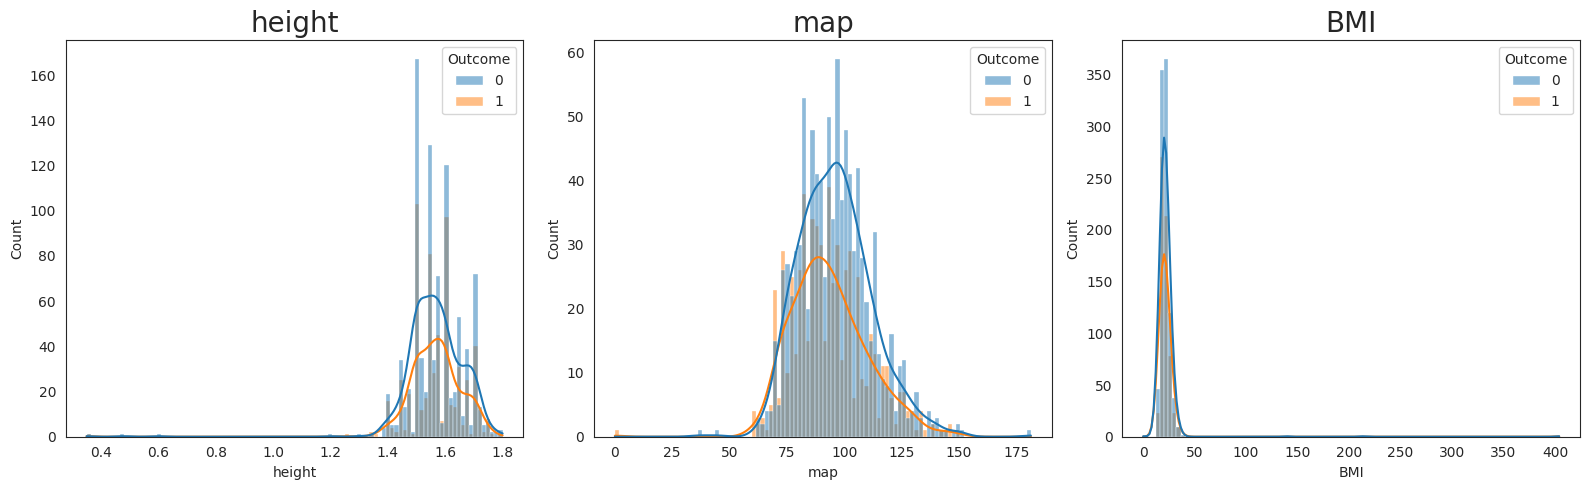

In [ ]:
plot_stratified_distributions(binarized_train[['height','map','BMI','Outcome']], n_col=3, outcm=0)

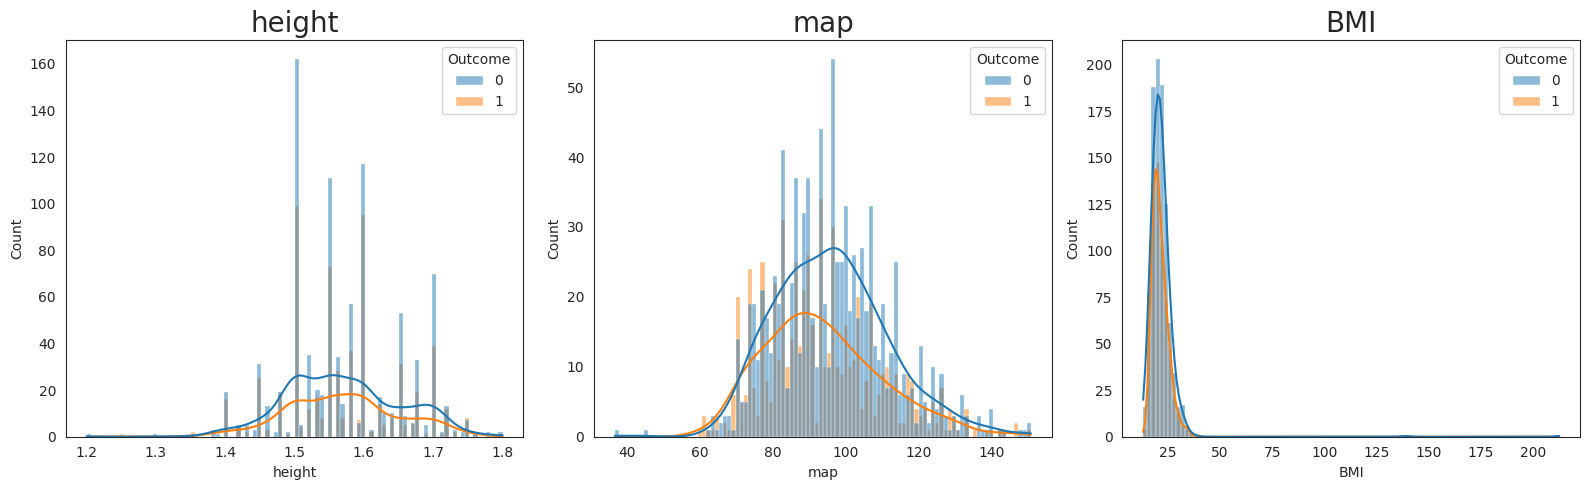

In [ ]:
plot_stratified_distributions(train_set[['height','map','BMI','Outcome']], n_col=3, outcm=0)

# Handling NaN

In [ ]:
train_no_outliers = train_set.copy()
test_no_outliers = test_set.copy()
print(train_set.shape)
print(test_set.shape)

(1556, 153)
(390, 153)


### Dropping features with to many missing values

In [ ]:
# drop columns with >= 30% NaN
train_dropped, test_dropped, dropped_columns = drop_NaNfeatures_train_test(train_no_outliers, test_no_outliers, thr=30)

Train dropped columns are: 1 
 ['left.ventricular.end.diastolic.diameter.LV']
The removed columns in test correspond:  True


In [ ]:
print(train_dropped.shape)
print(test_dropped.shape)

(1556, 152)
(390, 152)


### Dropping patients with to many missing values

In [ ]:
# Keep only the rows with at least 60% non-NA values

# drop rows with >= 60% NaN
train_drop = train_dropped.dropna(thresh = train_dropped.shape[1]*0.6, axis = 0, inplace = False)
test_drop = test_dropped.dropna(thresh = test_dropped.shape[1]*0.6, axis = 0, inplace = False)

In [ ]:
print(train_drop.shape)
print(test_drop.shape)

(1556, 152)
(390, 152)


### Missing values imputation

In [ ]:
train_no_outliers = train_drop.copy()
test_no_outliers = test_drop.copy() 

In [ ]:
#divide dataset to impute value according to the outcome (stratified imputation)
train_set_outcome0 = train_no_outliers[train_no_outliers['Outcome'] == 0]
train_set_outcome1 = train_no_outliers[train_no_outliers['Outcome'] == 1]
test_set_outcome0 = test_no_outliers[test_no_outliers['Outcome'] == 0]
test_set_outcome1 = test_no_outliers[test_no_outliers['Outcome'] == 1]

In [ ]:
def impute_NaN(train_set, test_set):

  """ Function that extracts known values of each variable that contains NaN
      Given these values, variable distribution is estimated with KernelDensity
      Using the distribution, missing values of each variable are imputed both on train and test set
  """

  for col in train_set.columns[train_set.isna().any()]:
    known_values = train_set[col][~train_set[col].isna()].values.reshape(-1,1)    #extract known values only
    kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.2).fit(known_values)   #estimate their distribution with KernelDensity
    train_missing_count = train_set[col].isna().sum()                             #count of NaN for each variable
    train_imputed_values = kde.sample(train_missing_count)                        #imputing values
    train_set.loc[train_set[col].isna(), col] = train_imputed_values.flatten()    #replace imputed values

  for col in test_set.columns[test_set.isna().any()]:
    known_values = train_set[col][~train_set[col].isna()].values.reshape(-1,1)
    kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.2).fit(known_values)
    test_missing_count = test_set[col].isna().sum()
    test_imputed_values = kde.sample(test_missing_count)  
    test_set.loc[test_set[col].isna(), col] = test_imputed_values.flatten()

  return train_set, test_set

In [ ]:
#imputation
train0_imputed, test0_imputed = impute_NaN(train_set_outcome0, test_set_outcome0)
train1_imputed, test1_imputed = impute_NaN(train_set_outcome1, test_set_outcome1)

In [ ]:
#check on NaNs
print("Imputed train and test (outcome 0) do not present NaN values:", train0_imputed.isna().sum().sum() == 0 and test0_imputed.isna().sum().sum() == 0)
print("Imputed train and test (outcome 1) do not present NaN values:", train1_imputed.isna().sum().sum() == 0 and test1_imputed.isna().sum().sum() == 0)

Imputed train and test (outcome 0) do not present NaN values: True
Imputed train and test (outcome 1) do not present NaN values: True


In [ ]:
#merge
train_set_merged = pd.concat([train0_imputed, train1_imputed])
test_set_merged = pd.concat([test0_imputed, test1_imputed])

In [ ]:
#check on shape
print("Train set has same shape than before imputation:", train_set_merged.shape == train_no_outliers.shape)
print("Test set has same shape than before imputation:", test_set_merged.shape == test_no_outliers.shape)

Train set has same shape than before imputation: True
Test set has same shape than before imputation: True


In [ ]:
#Final check for outliers
print("Number of outliers in train is zero:", train_set_merged.isna().sum().sum() == 0)
print("Number of outliers in test is zero:", test_set_merged.isna().sum().sum() == 0)

Number of outliers in train is zero: True
Number of outliers in test is zero: True


# Feature Exploration


In [ ]:
train_set = train_set_merged.copy()
test_set = test_set_merged.copy()
print(train_drop.shape)
print(test_drop.shape)

(1556, 152)
(390, 152)


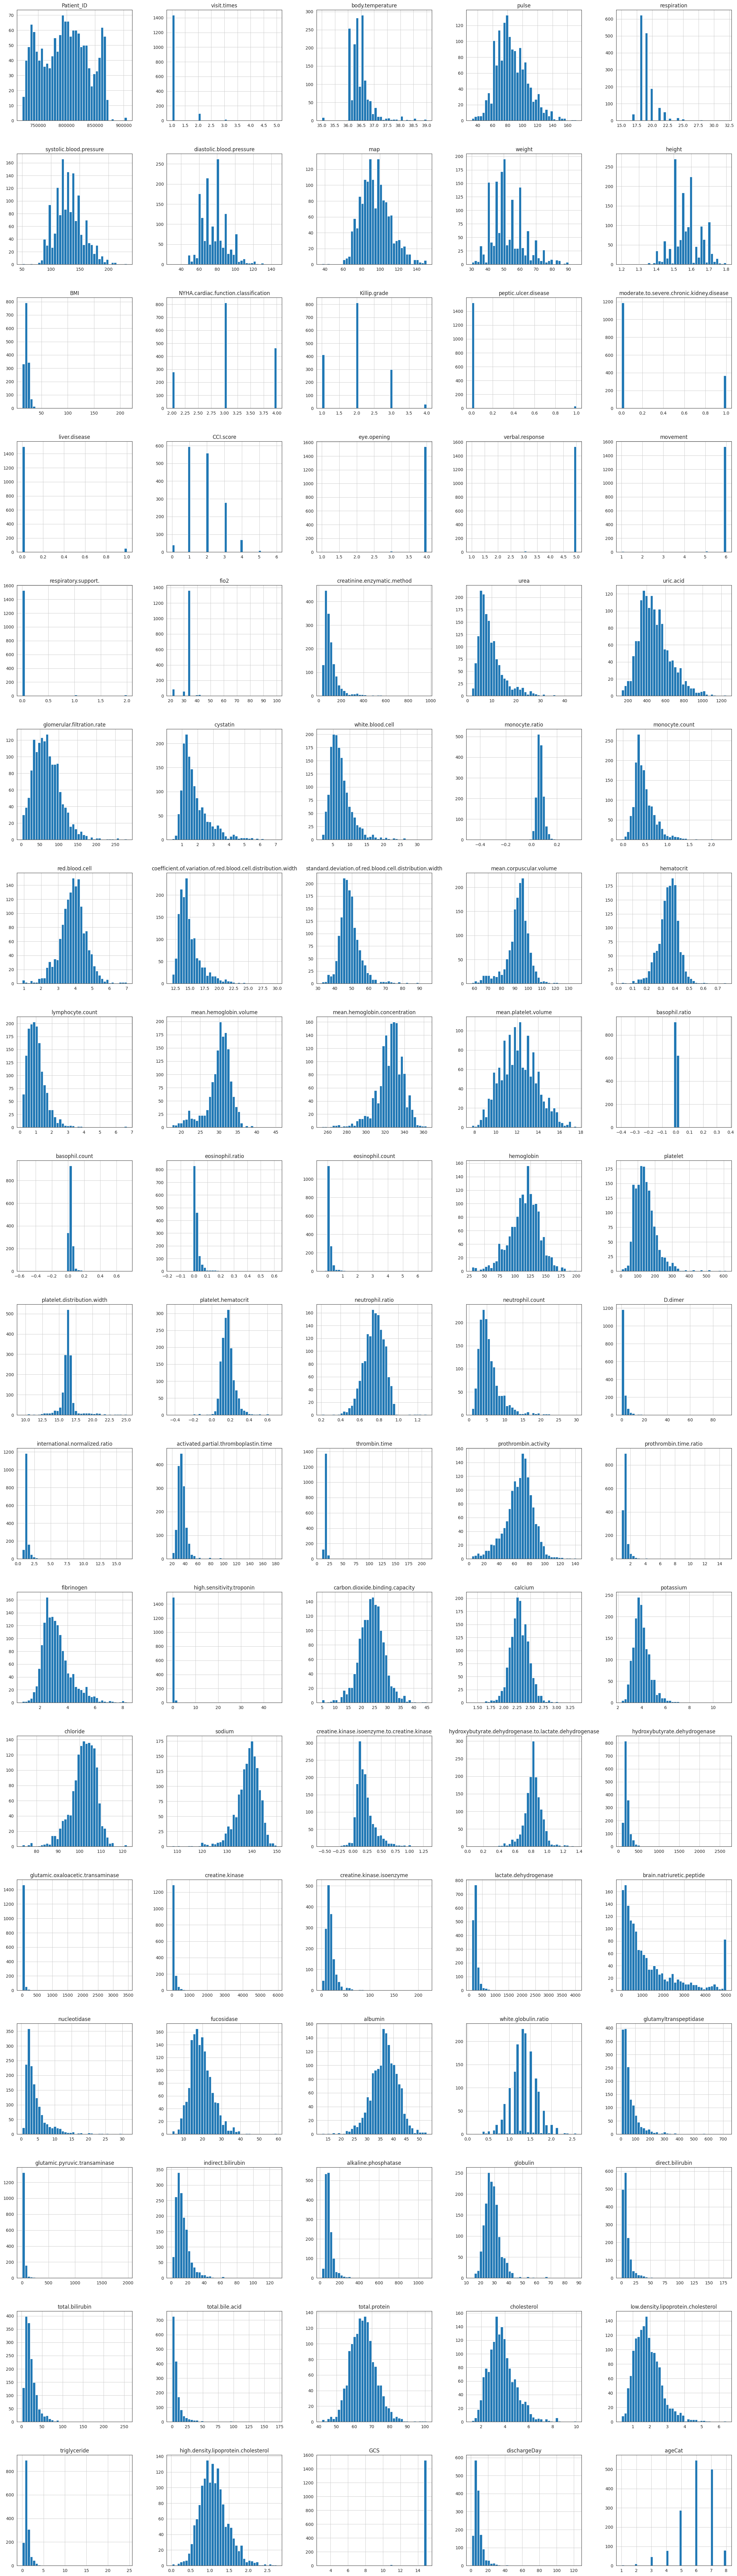

In [ ]:
# Determine the number of variables and calculate the layout
numericals_nb = select_nonbinary(train_set)
num_vars = len(numericals_nb)
num_cols = 5
num_rows = (num_vars + num_cols - 1) // num_cols  # Round up to the nearest integer

# Plot the histograms with the updated layout
train_set[numericals_nb].hist(layout=(num_rows, num_cols), figsize=(30, 6 * num_rows), bins=40)
plt.show()

In [ ]:
#exponential variables
exponentials = ['D.dimer','brain.natriuretic.peptide','eosinophil.count','eosinophil.ratio','glutamyltranspeptidase','high.sensitivity.troponin','total.bile.acid']
len(exponentials)           

7

In [ ]:
#adding a column for each exponential with its log transformation
import math
log_exp = []

for column in exponentials:
  train_set['log.'+ column] = train_set[column].apply(lambda x: math.log(x+1))
  log_exp.append('log.'+ column)

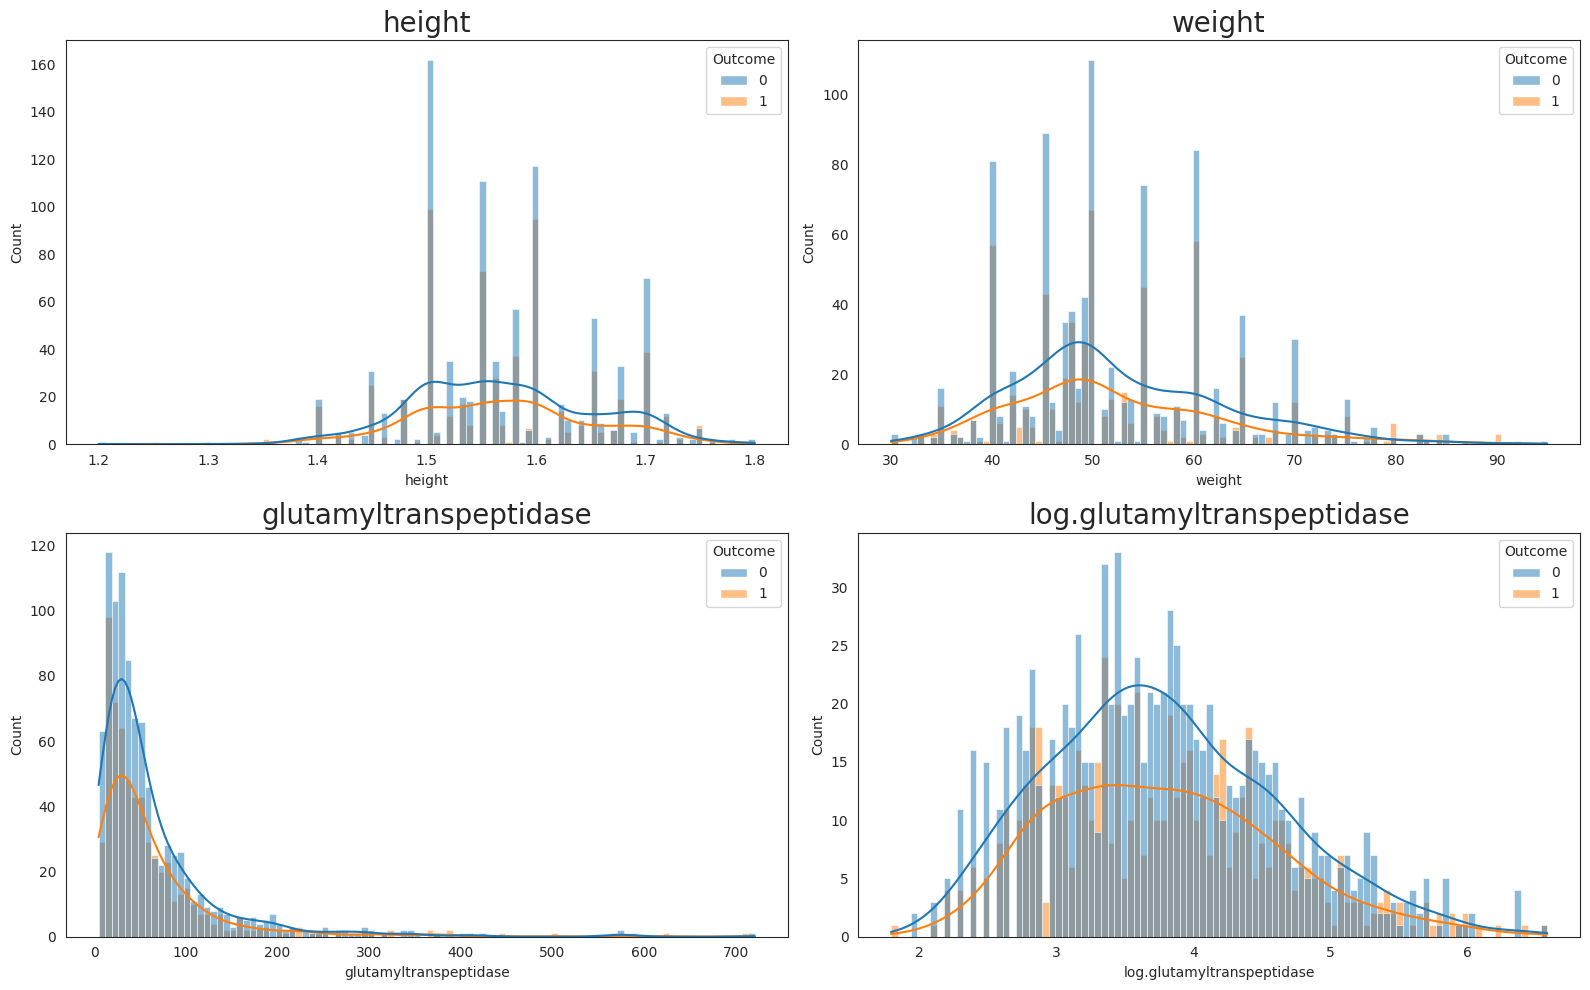

In [ ]:
plot_stratified_distributions(train_set[['height','weight','glutamyltranspeptidase', 'log.glutamyltranspeptidase','Outcome']], n_col=2, outcm=0)

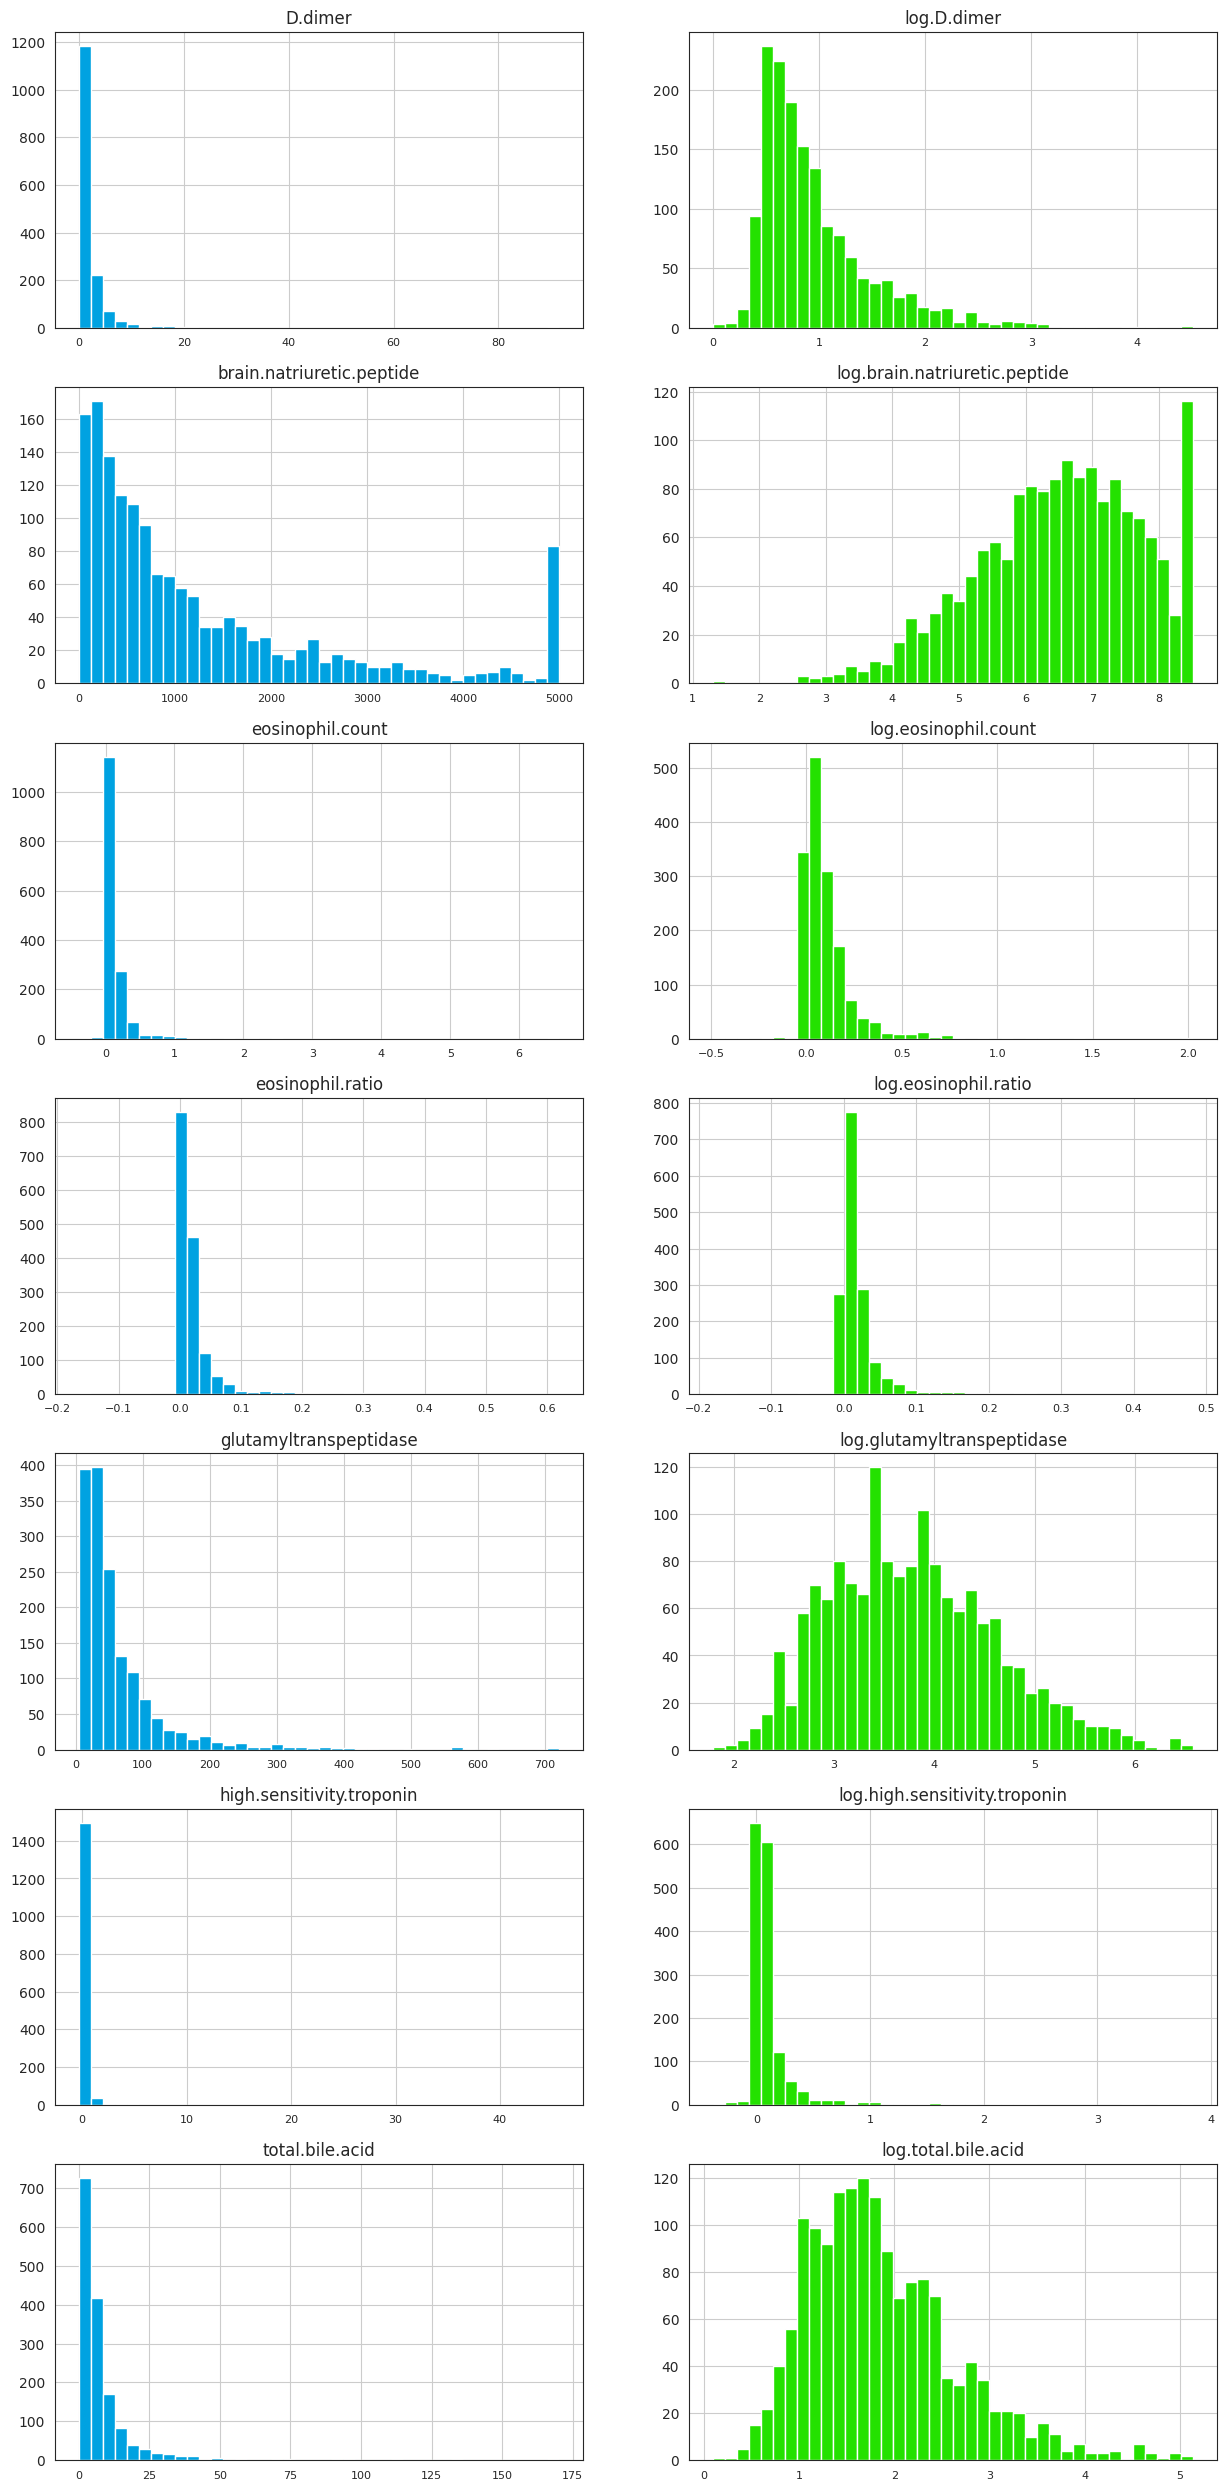

In [ ]:
#plot before and after log transformation
import scipy.stats as stats

plt.figure(figsize = (15,50))
for i in range(len(exponentials)):
  plt.subplot(11, 2, i*2+1)
  train_set[exponentials[i]].hist(bins=40, color='#00a2e1')
  plt.title(exponentials[i],fontsize=12)
  plt.xticks(fontsize=8)
  plt.subplot(11, 2, i*2+2)
  train_set[log_exp[i]].hist(bins=40, color='#24e100')
  plt.xticks(fontsize=8)
  plt.title(log_exp[i], fontsize=12)


In [ ]:
#do the same transformations also on test set
for column in exponentials:
  test_set['log.'+ column] = test_set[column].apply(lambda x: math.log(x+1))

In [ ]:
#drop now exponentials columns leaving log-transformed ones
train_set.drop(columns = exponentials, inplace = True) 
test_set.drop(columns = exponentials, inplace = True) 

In [ ]:
print(train_set.shape) 
print(test_set.shape) 

(1556, 152)
(390, 152)


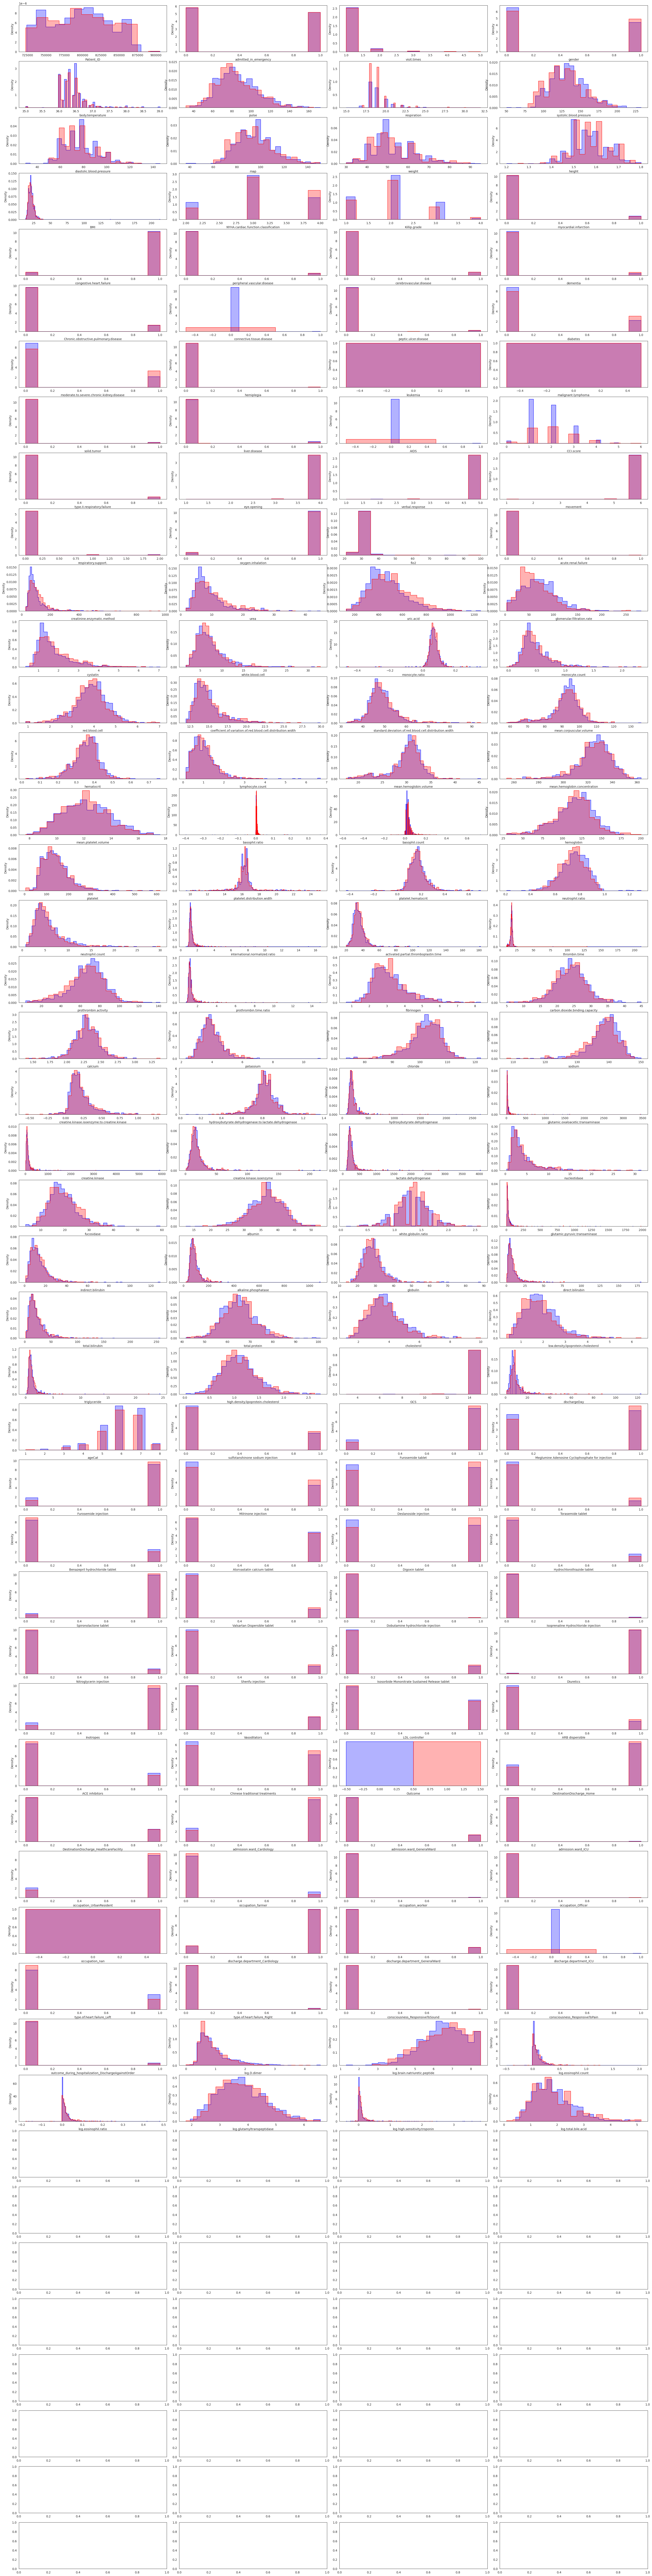

In [ ]:
X0 = train_set[train_set['Outcome']==0]
X1 = train_set[train_set['Outcome']==1]

fig, axes = plt.subplots(ncols=4, nrows=46, figsize=(30,120))
fig.tight_layout() 

for i, ax in zip(range(train_set.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

#Save dataset




In [ ]:
print(train_set.shape) 
print(test_set.shape) 

(1556, 152)
(390, 152)


In [ ]:
train_set.to_csv('Data/train_2605.csv') 
test_set.to_csv('Data/test_2605.csv')   